## This notebook investigates the popular 'perpetual swap' arbitrage on crytpo markets.

1a) First we take a look at perpetual swaps and 'cash and carry' arbitrage opportunities. <br>
1b) We derive the mathematical foundations. <br>
2) Then we take a look on empiricial opportunities. <br>
3) Finally we take a look at CPI arbitrage.

### Data:
- We gather data from binance.com, the largest perpetual swaps marketplace.
- The data for the two most liquid markets (BTC/USDT and ETH/USDT) consists of 8h intervals from 11/2019-03/2022.
- We gather both spot data as well as derivative data from the same exchange, thus arbitrageurs have minimal barriers to access opportunities.


### 1a) About perpetual swaps and 'cash and carry' arbitrage

Perpetual swaps are very short-term futures.
- Perpetual swaps are very short-term futures, whereas a 'funding rate' is used to keep the price between the derivative and index in balance.
- The funding rate is higher (lower) the higher (lower) the derivative trades above (below) the underlying index.
- Every 8h the long position pays the short position - vice versa if the funding rate is negative.
- The perpetual swaps is the most popular financial instruments in crypto markets. Perpetual swaps account for USD 75-125 billion daily traded volume, whereas 40-60% is traded on Binance.com.

Crypto markets have some interesting unique properties.
- Due to the absence of prime broker and scattered trading venues, margins might be posted seperately for both sides of the trade. This makes trading capital intensive.
- Trading in crypto markets occurs 24/7. Regular cash-settled future instruments (e.g. as offered by the Chicago CME) has low demand, due to the troubles of managing margin during non-banking hours.

Cash and carry trade for perpetual swaps
- Using the cost of carry model from Fama and French (1988), we can write the the price of a future contract in t ($F_t$) as function of the spot price ($S_t$), the risk free rate ($r_t$), the costs of storage ($w_t$) and the cost of convenience ($y_t$):
$F_t^T = S_t * T * (r_t^T+w_t^T-y_t^T)$

- On crypto markets the funding rate $fr_t$ would be the combined compensation for the costs of capital, storage and convenience.
- As we will see the funding rate already includes a fair parameter for the risk free rate.
- The cost of storage could be interpreted as the default-risk premia to store collateral on a crypto exchange. However, leading crypto exchanges insure collateral with an in-house insurance fund, akin to deposit insurance in traditional banking.
- Thus, one could argue that the funding rate is mostly driven by the cost of convenience.

It is possible to exploit the cost of convenience.
- The funding rate consists of a premium component and a fixed interest rate component $fundingrate_t = premium_t + interest$.
- The interest rate $i$ component is fixed to compensate for difference of capital costs between the base and the quoted asset.
- The premium is the deviation between the spot and the derivative price $(F_t/S_t)-1$.
- The funding rate can be defined as $fundingrate_t = fr_t = (F_t/S_t)-1 + i$
- If the funding rate is positive (i.e. the price of the deriviative is larger than the price of the index), long positions have to pay short positions. This incentivizes more short positions and promotes the equilbrium between derivative and spot.
- If the funding rate is negative (i.e. the price of the deriviative is below the price of the index), short positions have to pay long positions. This incentivizes more long positions and promotes equilbrium between derivative and spot.
- There exists a strategy to capture the funding rate payments by going either long or short the perpetual swap.
- The price risk can be hedged by taking the opposite direction on the spot market.
- Holding both till expiry will yield the funding rate over time.
- Note: we do not consider fees and margin requirements.

![](perp_swap.png)

###### 

### 1b) Mathematical foundations
We explore the limits and calculation of the perpetual swap arbitrage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

pd.options.mode.chained_assignment = None

In [ ]:
# Setting the index price to 100, and fluctuating the perpetual price. The interest rate is market typical and set to 0.01% each 8h.
# This is equivalent to 9.5% per annum.
index = 100
interest = 0.0001
perp = np.arange(98, 102, 0.01)

In [ ]:
#implementing arbitrage when the funding rate is positive
def positive(perp, index, interest, fee):
    premium = (perp/index)-1
    fr_8h = (premium + interest)
    rtrn = fr_8h/2 - fee
    return rtrn*3*365

#implementing arbitrage when the funding rate is negative
def negative(perp, index, interest, fee):
    premium = (perp/index)-1
    fr_8h = premium + interest
    rtrn = -1*(fr_8h)/2 - fee
    return rtrn*3*365

fig, axs = plt.subplots(1,2, figsize=(15, 6), sharey=True)

fee = 0.0000
axs[0].plot(perp/index-1, positive(perp, index, interest, fee), 'b-')
axs[0].plot(perp/index-1, negative(perp, index, interest, fee), 'g-')

fee = 0.0005
axs[1].plot(perp/index-1, positive(perp, index, interest, fee), 'b--')
axs[1].plot(perp/index-1, negative(perp, index, interest, fee), 'g--')
axs[1].plot([-.0009,.0007], [0,0], 'r-')
axs[1].plot([.0007,.015], [0,7.5], 'r-')
axs[1].plot([-.015,-.0009], [7.5,0], 'r-')

for i in range(0,2):
    axs[i].set_ylim(-2.5,2.5)
    axs[i].set_xlim(-0.01,0.01)

    vals = axs[i].get_xticks()
    axs[i].set_xticklabels(['{:,.1%}'.format(x) for x in vals])

    vals = axs[i].get_yticks()
    axs[i].set_yticklabels(['{:,.0%}'.format(x) for x in vals])

    axs[i].set_xlabel('Deviation: Perp/Index')
    axs[0].set_ylabel('Return of Strategy')
    axs[0].legend(['Positive $fr_t$: short', 'Negative $fr_t$: long'], loc='upper right')
    axs[1].legend(['Positive $fr_t$ (incl fees)', 'Negative $fr_t$ (incl fees)', 'Perfect strategy (incl fees)'], loc='upper right')
    
txt = 'The figure displays returns from arbitraging the funding rate. If the funding rate is positive (negative) one shorts (longs) the derivative and longs (shorts) the spot. \n The return is large, when the deviation between the derivative and spot widens. However, the return is heavily dependent on fees and margin management. The right chart introduces (5bps) fees. \n The red line depicts a perfect arbitrageur, i.e. perfect timing the funding rates and refraining from trades, if the returns are smaller then the costs.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

### 2) Empirical arbitrage opportunities
The funding rate has been significant in the past. We calculate the returns on the above mentioned strategy on the historical data. We calculate the return in two fashions: with and without compounding effects (reinvesting the profits into the strategy).
We assume no fees, liquidation risk and efficient markets (shorting is possible).

In [2]:
#load relevant data
funding_rate = pd.read_csv('rate_eth_usdt.csv', parse_dates=['timestamp'])
funding_rate = funding_rate.rename(columns={'rate': 'funding_rate'})
perp = pd.read_csv('perp_eth_usdt_1h.csv', parse_dates=['timestamp'])
spot = pd.read_csv('spot_eth_usdt_1h.csv', parse_dates=['timestamp'])

#rate_sample = rate[(rate['timestamp'] >= '2021-03-01') & (rate['timestamp'] <= '2022-03-01')].reset_index(drop=True)
#perp_sample = perp[(perp['timestamp'] >= '2021-03-01') & (perp['timestamp'] <= '2022-03-01')].reset_index(drop=True)
#spot_sample = spot[(spot['timestamp'] >= '2021-03-01') & (spot['timestamp'] <= '2022-03-01')].reset_index(drop=True)

In [ ]:
#take a look at the funding rate over time
df = funding_rate[['epoch', 'timestamp', 'funding_rate']]
df = pd.merge(df,
                 spot[['epoch', 'close']],
                 on='epoch', 
                 how='left')

fig, ax = plt.subplots(figsize =(10,4))

ax.plot(df['timestamp'], df['funding_rate'])
secax = ax.twinx()
secax.plot(df['timestamp'], df['close'], color = 'orange')
secax.set_yscale('log')
secax.set_yticks([])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.set_ylabel('8h funding rate')

txt = 'The figure displays the 8h funding rate of the ETH/USDT perpetual swap on Binance from 11/2019 to 03/2022. The orange line denotes the log of the price over time. \n The funding rate tends to decline over time.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

In [ ]:
#We now calculate common statistics, such as standard deviation, return, maximum drawdown.
#create a dataframe for the calculations
df = funding_rate.copy()
df['pf'] = 0.0

#calculate the return capturing the funding rate over time. Note: This calculation includes compounding effects.
df['pf'][0] = 1 * (1+df['funding_rate'][0])
for i in range(1,len(df)):
    df['pf'][i] = df['pf'][i-1]*(1+df['funding_rate'][i])

In [ ]:
#calculate and plot maxmimum drawdown
window = 3*365 #one year

roll_max = df['pf'].rolling(window, min_periods=1).max()

daily_drawdown = df['pf']/roll_max - 1.0
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

fig, ax = plt.subplots(figsize =(10,4))

ax.plot(df['timestamp'], daily_drawdown)
ax.plot(df['timestamp'], max_daily_drawdown)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.legend(['daily drawdown', 'maximum drawdown'])
ax.set_ylabel('8h funding rate')

txt = f'The figure displays the possible drawdowns for perpetual swap arbitrage on Binance from 11/2019 to 03/2022. \n The maximum drawdown at {np.round(daily_drawdown.min()*100,2)}% is suprisingly small.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

In [ ]:
#standard deviation
std = df['funding_rate'].std()
std_annualized = std * np.sqrt(3*365)

#calculating the return without compounding effect.
mreturn = df['funding_rate'].mean()
mreturn_annualized = mreturn*3*365

#calculating sharpe ratio, yet without substracting a risk free component
sharpe = (mreturn_annualized/std_annualized)


print('Capturing the funding rate since the start would have compounded in a gain of:', np.round((df['pf'].iloc[-1]-1)*100,2), '%')
print(np.round(mreturn_annualized*100, 2), '% mean return (annualized)')
print(np.round(std_annualized*100, 2), '% standard deviation (annualized)')
print(np.round(sharpe,2), 'sharpe ratio (annualized)')
print(np.round(daily_drawdown.min()*100,2), '% maximum drawdown')

In [ ]:
#splitting the statistics into years
df_2019 = df[(df['timestamp'] < pd.to_datetime('2020-01-01'))].reset_index(drop=True)
df_2020 = df[(df['timestamp'] >= pd.to_datetime('2020-01-01')) & (df['timestamp'] < pd.to_datetime('2021-01-01'))].reset_index(drop=True)
df_2021 = df[(df['timestamp'] >= pd.to_datetime('2021-01-01')) & (df['timestamp'] < pd.to_datetime('2022-01-01'))].reset_index(drop=True)
df_2022 = df[(df['timestamp'] >= pd.to_datetime('2022-01-01'))].reset_index(drop=True) 

results = pd.DataFrame(
    {'mean return': [np.round(df_2019['funding_rate'].mean()*3*365,4), np.round(df_2020['funding_rate'].mean()*3*365,4), np.round(df_2021['funding_rate'].mean()*3*365,4), np.round(df_2022['funding_rate'].mean()*3*365,4)],
    'standard deviation': [np.round(df_2019['funding_rate'].std()*np.sqrt(3*365),4), np.round(df_2020['funding_rate'].std()*np.sqrt(3*365),4), np.round(df_2021['funding_rate'].std()*np.sqrt(3*365),4), np.round(df_2022['funding_rate'].std()*np.sqrt(3*365),4)]},
                  index = ['2019', '2020', '2021', '2022'])
results['sharpe ratio'] = [np.round(results['mean return'].iloc[0]/results['standard deviation'].iloc[0],2), np.round(results['mean return'].iloc[1]/results['standard deviation'].iloc[1],2), np.round(results['mean return'].iloc[2]/results['standard deviation'].iloc[2],2), np.round(results['mean return'].iloc[3]/results['standard deviation'].iloc[3],2)]
results

In [3]:
#Funding rate consists of the premium and interest. We assume the premium is the significant variable.
#The premium is the deviation between perp and spot. We want to check how large the deviation between perp and spot has been historically.

#create a panel
panel = funding_rate[['epoch', 'timestamp', 'funding_rate']]

panel = pd.merge(panel,
                 perp[['epoch', 'open', 'volume']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'open': 'perp', 'volume': 'vol_perp'})

panel = pd.merge(panel,
                 spot[['epoch', 'open', 'volume']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'open': 'spot', 'volume': 'vol_spot'})

In [10]:
panel

,epoch,timestamp,funding_rate,perp,vol_perp,spot,vol_spot
0,1574841600,2019-11-27 09:00:00,0.000100,125.03,0.080,146.28,11989.25169
1,1574870400,2019-11-27 17:00:00,0.000100,150.72,9478.530,150.67,41449.66642
2,1574899200,2019-11-28 01:00:00,0.000100,154.29,36.520,152.61,8553.57197
3,1574928000,2019-11-28 09:00:00,0.000014,152.04,6100.715,152.23,20137.27914
4,1574956800,2019-11-28 17:00:00,-0.000106,153.78,5282.140,153.97,16824.95914
...,...,...,...,...,...,...,...
2531,1647734400,2022-03-20 01:00:00,0.000100,2949.90,53384.380,2950.85,12114.42900
2532,1647763200,2022-03-20 09:00:00,0.000100,2925.00,22562.482,2925.48,6930.47290
2533,1647792000,2022-03-20 17:00:00,0.000100,2854.42,100055.944,2853.94,24922.57030
2534,1647820800,2022-03-21 01:00:00,0.000100,2860.53,42044.077,2861.39,11464.49110


In [155]:
#assumption: 10mn volume; using BNB; maker; usdt; only short derivative; no slippage
#trading strategy: if positive funding rate, short derivative and long spot; otherwise no trade

#funding rate is calculated every 5sec and aggreated as simple 8h moving average (12*60*8 datapoints).
#funding settlements are every 8 hours
#"Traders are only liable for funding payments in either direction if they have open positions at the pre-specified funding times"
#https://www.binance.com/en/support/faq/360033525031

fee_derivative = 0.00018
fee_spot = 0.0006

notional = 1000000
leverage = 1
margin = notional/2/leverage

In [156]:
def open_position():
    position_spot = share_spot*notional/(ethusdt_spot *(1+fee_spot))
    position_der = share_der*notional/(ethusdt_perp *(1+fee_derivative))
    fee = (share_spot*notional*fee_spot+share_der*notional*fee_derivative)*-1
    return position_spot, position_der, fee

def close_position():
    position_spot = 0
    position_der = 0
    fee = (share_spot*notional*fee_spot+share_der*notional*fee_derivative)*-1
    return position_spot, position_der, fee


share_spot = (1-fee_derivative)/(2-fee_spot-fee_derivative)
share_der = 1-share_spot

In [159]:
#strating variables
lst=[]
position_open = 0
position_spot = 0.0
position_der = 0.0
payment = 0.0

for i in range(0, len(panel)):
    ethusdt_spot = panel['spot'][i]
    ethusdt_perp = panel['perp'][i]
    funding_rate = panel['funding_rate'][i]
    fee = 0.0
    
    #trading strategies
    if (funding_rate > 0) & (position_open == 0):
        position_open = 1
        position_spot, position_der, fee = open_position()
        payment = share_der*notional*funding_rate
    elif (funding_rate > 0) & (position_open == 1):
        payment = share_der*notional*funding_rate
    elif (funding_rate <= 0) & (position_open == 0):
        payment = 0.0
    elif (funding_rate <= 0) & (position_open == 1):
        position_open = 0
        position_spot, position_der, fee = close_position()
        payment = 0.0
        
    lst.append([panel['epoch'][i], panel['timestamp'][i], position_open, position_spot, position_der, fee, funding_rate, payment])
    

In [214]:
df = pd.DataFrame(lst, columns=['epoch', 'timestamp', 'position_open', 'position_spot', 'position_der', 'fee', 'funding_rate', 'payment'])

df['PnL'] = df['payment'].rolling(3*365, min_periods=1).sum() + df['fee'].rolling(window, min_periods=1).sum()
standard_deviation = int(df['payment'].std()*np.sqrt(3*365))

payment = int(df['payment'].mean()*3*365) #annualized
fees = int(df['fee'].mean()*3*365) #annualized
print(f'The simple strategies pays ${payment} (annualized) with ${fees} in fees. The annual PnL is ${payment+fees}, i.e. {np.round((payment+fees)/notional,4)*100}%.')

The simple strategies pays $147832 (annualized) with $-30146 in fees. The annual PnL is $117686, i.e. 11.77%.


In [231]:
#splitting the statistics into years
df_2019 = df[(df['timestamp'] < pd.to_datetime('2020-01-01'))].reset_index(drop=True)
df_2020 = df[(df['timestamp'] >= pd.to_datetime('2020-01-01')) & (df['timestamp'] < pd.to_datetime('2021-01-01'))].reset_index(drop=True)
df_2021 = df[(df['timestamp'] >= pd.to_datetime('2021-01-01')) & (df['timestamp'] < pd.to_datetime('2022-01-01'))].reset_index(drop=True)
df_2022 = df[(df['timestamp'] >= pd.to_datetime('2022-01-01'))].reset_index(drop=True) 

results = pd.DataFrame(
    {'payment': [int(df_2019['payment'].mean()*3*365), int(df_2020['payment'].mean()*3*365), int(df_2021['payment'].mean()*3*365), int(df_2022['payment'].mean()*3*365)],
    'fee': [int(df_2019['fee'].mean()*3*365), int(df_2020['fee'].mean()*3*365), int(df_2021['fee'].mean()*3*365), int(df_2022['fee'].mean()*3*365)]},
    index = ['2019', '2020', '2021', '2022'])
results['PnL'] = results['payment'] + results['fee']
results['PnL_percent'] = np.round(results['PnL']/notional,4)
results

,payment,fee,PnL,PnL_percent
2019,48033,-20533,27500,0.0275
2020,139439,-17115,122324,0.1223
2021,191195,-21062,170133,0.1701
2022,31148,-135813,-104665,-0.1047


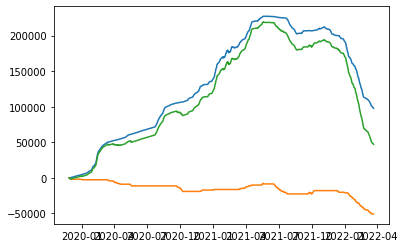

In [197]:

plt.plot(df['timestamp'], df['payment'].rolling(window, min_periods=1).sum())
plt.plot(df['timestamp'], df['fee'].rolling(window, min_periods=1).sum())
plt.plot(df['timestamp'], PnL)


In [201]:
PnL

0        -340.054621
1        -290.065125
2        -240.075629
3        -233.072101
4        -623.116218
            ...     
2531    48036.981344
2532    47831.524516
2533    47368.391832
2534    47077.133033
2535    47077.133033
Length: 2536, dtype: float64

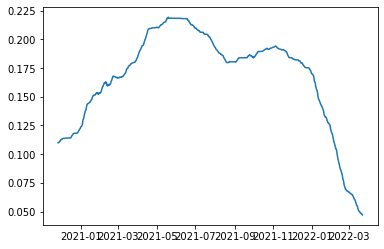

In [199]:
plt.plot(df['timestamp'].iloc[3*365:], PnL.iloc[3*365:]/notional)

In [ ]:
#funding_rate is a management of slipage & fees
#funding_rate is a game of swings!

In [ ]:
#statistics
#sensitivity

In [ ]:
#calculate and plot the average deviation of perp and spot
panel['deviation'] = (panel['perp']-panel['spot'])/panel['spot']

fig, ax = plt.subplots(figsize =(10,4))

#omitting first value, as initial listing is outlier
ax.scatter(panel['timestamp'].iloc[1:], panel['deviation'].iloc[1:], s=2.5)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

ax.set_ylabel('deviation of perp and spot')

mean = np.round(panel['deviation'].mean(),4)

txt = f'The figure displays the deviation of perps vs. spot on Binance from 11/2019 to 03/2022. \n The mean devation is {mean*100}%.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

In [ ]:
#take a look at the distribution
panel = panel.iloc[1:]
panel = panel.dropna()

fig, ax = plt.subplots(figsize =(4,8))
ax.boxplot(panel['deviation'])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

txt = f'The figure displays the distribution of the deviation. \n It is quite compact around the mean, however there are several outliers for a positive deviation, i.e. the perp traded above the spot.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()


We want to test different hypotheses about the relationship of the funding rate with other market parameters.
- H1: The funding rate is impacted by the returns of the underlying. The funding rate is high during bull markets.
- H2: The funding rate is impacted by volatility in the market. The spread between perpetual and index widens.
- H3: The funding rate is impacted by volume in the market. High volumes decreased the spread between perpetual and index.
- H_future: The funding rate is impacted by retail involvement. -> How to test?

In [ ]:
import statsmodels.formula as smf
import statsmodels.api
import statsmodels.stats as ss

In [ ]:
funding_rate = pd.read_csv('rate_eth_usdt.csv', parse_dates=['timestamp'])
perp = pd.read_csv('perp_eth_usdt_1h.csv', parse_dates=['timestamp'])
spot = pd.read_csv('spot_eth_usdt_1h.csv', parse_dates=['timestamp'])

#rate_sample = rate[(rate['timestamp'] >= '2021-03-01') & (rate['timestamp'] <= '2022-03-01')].reset_index(drop=True)
#perp_sample = perp[(perp['timestamp'] >= '2021-03-01') & (perp['timestamp'] <= '2022-03-01')].reset_index(drop=True)
#spot_sample = spot[(spot['timestamp'] >= '2021-03-01') & (spot['timestamp'] <= '2022-03-01')].reset_index(drop=True)

In [ ]:
#We prepare a simpel panel for the regression. Note: The funding rate is measured every 8h. We gather the prices of perpetual swaps and and spot every hour.
#Thus we map all the data on equal timestamps, resulting in 8h intervals over 2.5 years.

panel = funding_rate[['epoch', 'timestamp', 'rate']]
panel = panel.rename(columns={'rate': 'funding_rate'})

panel = pd.merge(panel,
                 perp[['epoch', 'open', 'volume']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'open': 'perp', 'volume': 'vol_perp'})

panel = pd.merge(panel,
                 spot[['epoch', 'open', 'volume']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'open': 'spot', 'volume': 'vol_spot'})



In [ ]:
panel['vol_spot_perp'] = panel['vol_spot']/panel['vol_perp']

In [ ]:
#calculate funding_rate t-1
panel['previous_funding_rate'] = panel['funding_rate'].shift(1)
#calculate spot return
panel['return_t'] = (panel['spot'] - panel['spot'].shift(1))/panel['spot'].shift(1)
#7days standard deviation
panel['std_7d'] = panel['spot'].rolling(3*7).std()

In [ ]:
panel = panel.dropna().reset_index(drop=True)

In [ ]:
results = smf.api.ols('funding_rate ~ return_t + previous_funding_rate + std_7d + vol_perp + vol_spot + vol_spot_perp', data = panel).fit()
results.summary2()


The returns on the spot market, the previous funding rate $fr_{t-1}$ as well as the trading volume on the perpetual market are statistically significant. 
Suprisingly the volatiliy does not have and impact.
Overall the variables explain 57.6% ($R^2$) of the overall variance.

- H1: The funding rate is impacted by the returns of the underlying. The funding rate is high during bull markets. -> not rejected
- H2: The funding rate is impacted by volatility in the market. The spread between perpetual and index widens. -> rejected
- H3: The funding rate is impacted by volume in the market. High volumes decreased the spread between perpetual and index. -> not rejected

### 3) CIP arbitrage

Lastly we study deviations from the covered interest parity. The CIP dictates the relation between spot, futures and interest rate differentials.
Whereas the CIP devation is violated if $(i_{t}^{USD}-i_{t}^{CRYPTO})-(1/T)*(f_{t}^{T}-s_t)$ is larger or below zero.
- For example if the basis ($f_{t}^{T}-s_t$) is higher than the interest rate differential ($i_{t}^{USD}-i_{t}^{CRYPTO}$), an arbitrageur could sell the future, buy the spot financed with a USD loan, and invest the proceeds at the $i_{t}^{CRYPTO}$ interest rate.
- We scale the basis to match the maturity of the daily interest rate differential by multiplying with the time to maturity ($1/(T-t)$, i.e. 1/(3*365)
- We calculate the gross return (before substracting fees and transactions costs) and imply a trade size of \$1mn to account for slipage.
- We calculate the profitability for different thresholds $A$, for a strategy when the CIP violation is larger than $A=$\{0.1, 0.01, 0.001}

- As interest rate we take the compound.finance rates, it is as "close as big banks can borrow"


In [ ]:
spot = pd.read_csv('spot_eth_usdt_1h.csv', parse_dates=['timestamp'])
perp = pd.read_csv('perp_eth_usdt_1h.csv', parse_dates=['timestamp'])
i_crypto = pd.read_csv('interest_eth.csv')
i_usdt = pd.read_csv('interest_usdt.csv')
i_crypto['timestamp'] = pd.to_datetime(i_crypto['timestamp'], format='%d/%m/%Y %H.%M')
i_usdt['timestamp'] = pd.to_datetime(i_usdt['timestamp'], format='%d/%m/%Y %H.%M')
i_crypto = i_crypto.drop(columns=[i_crypto.columns[4]])
i_usdt = i_usdt.drop(columns=[i_usdt.columns[4]])
funding_rate_crypto = pd.read_csv('rate_eth_usdt.csv', parse_dates=['timestamp'])

In [ ]:
i_crypto['day'] = i_crypto['timestamp'].dt.round('D')
i_usdt['day'] = i_usdt['timestamp'].dt.round('D')
funding_rate_crypto['day'] = funding_rate_crypto['timestamp'].dt.round('D')

In [ ]:
panel = funding_rate_crypto[['epoch', 'timestamp', 'day', 'rate']]
panel = panel.rename(columns={'close': 'funding_rate'})

panel = pd.merge(panel,
                 spot[['epoch', 'close']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'close': 'spot'})


panel = pd.merge(panel,
                 perp[['epoch', 'close']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'close': 'perp'})

panel = pd.merge(panel,
                 i_crypto[['day', 'apy']],
                 on='day', 
                 how='right')
panel = panel.rename(columns={'apy': 'icrypto'})

panel = pd.merge(panel,
                 i_usdt[['day', 'apy']],
                 on='day', 
                 how='right')
panel = panel.rename(columns={'apy': 'iusdt'})


In [ ]:
T = 1/(3*365) #we receive interest every 8h for 365 days

# cip = interest rate differential - basis -> cip = yt - pt
panel['yt'] = panel['iusdt'] - panel['icrypto'] #the interest rate differential
panel['pt'] = -(1/T)*(np.log(panel['perp']) - np.log(panel['spot'])) #the basis
panel['cip'] = panel['iusdt'] - panel['icrypto'] - (1/T)*(np.log(panel['perp']) - np.log(panel['spot']))

#taking the absolute mean
mean = np.round(abs(panel['cip']).mean(),4)

print(f'The absolute mean deviation from the covered interest rate parity is {mean*100}%. Sampled from Binance over 500 days from 10/2020 till 03/2022.')

In [ ]:
#plotting the cip over time
fig, ax = plt.subplots(figsize =(10,4))

ax.scatter(panel['timestamp'], panel['yt'], s=2.5)
ax.scatter(panel['timestamp'], panel['pt'], s=2.5)


vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.legend(['yt', 'pt'], loc='lower right')
ax.set_ylabel('cip violation')

txt = f'The figure displays the cip violation, i.e. violations against the theoretical 0%. \n The basis (pt), the deviation between perp and spot is the significant component. The interest rate differential (yt) is irrelevant.'
fig.text(.5, -.1, txt, ha='center', fontstyle='italic')

plt.show()

In [ ]:
# We calculate the profitability for different thresholds  𝐴, for a strategy where the annualized CIP violation is larger than 𝐴={0.1, 0.01}
panel['abs_cip'] = abs(panel['cip'])
panel['return_8h'] = panel['abs_cip']*T

A = [1.0, 0.1, 0.01]

for j in range(0,len(A)):
    temp = panel[panel['abs_cip'] > A[j]]
    temp = temp.reset_index(drop=True)
    temp['pf'] = 0.0
    temp['pf'][0] = 1 * (1+temp['return_8h'][0])

    for i in range(1,len(temp)):
        temp['pf'][i] = temp['pf'][i-1]*(1+temp['return_8h'][i])

    result = np.round(temp['pf'].iloc[-1]-1, 6)
    print(f'Perfectly exploiting cip devation larger than 𝐴 = {A[j]}, yields {result*100}% (compounded) over the 500 trading days, equivalent to {np.round(result*100/(500/365), 2)}% per annum.')

In [ ]:


#1) CIP
#2) interest rate does not matter
#3) Perpetual trade -> implement w. different prices
#4) sensitivity

## Appendix

In [ ]:
#Tests for regression

# Adj R²
results.rsquared_adj

#scatter residuals
results.resid
plt.scatter(x=results.resid.index, y=results.resid)

# Durbin-Watson
dw = ss.stattools.durbin_watson(results.resid) #p-value
# JB 
jb = ss.stattools.jarque_bera(results.resid)
jb[1] # p-value
# KS
ks = ss.diagnostic.kstest_normal(results.resid)[1] #p-value
ks

In [ ]:
#calculating the funding rate based on the data
panel = spot[['epoch', 'timestamp', 'close']]
panel = panel.rename(columns={'close': 'spot'})

panel = pd.merge(panel,
                 perp[['epoch', 'close']],
                 on='epoch', 
                 how='left')
panel = panel.rename(columns={'close': 'perp'})

panel = panel.dropna()
#sample
panel = panel.iloc[::8, :]

panel['premium'] = (panel['perp']-panel['spot'])/panel['spot']

interest = 0.0001
panel['fr'] = (panel['premium'] + interest)

panel['fr'].mean()*3*365